/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


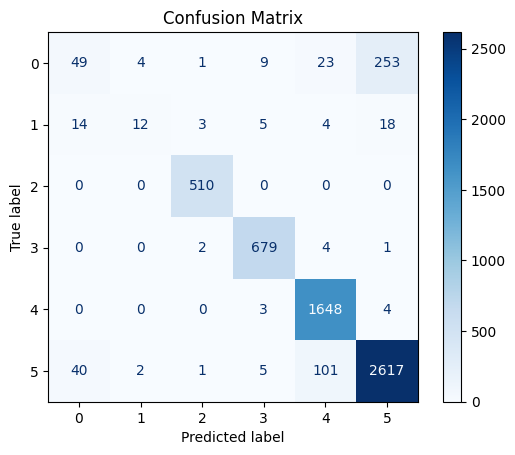


Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.14      0.22       339
           1       0.67      0.21      0.32        56
           2       0.99      1.00      0.99       510
           3       0.97      0.99      0.98       686
           4       0.93      1.00      0.96      1655
           5       0.90      0.95      0.92      2766

    accuracy                           0.92      6012
   macro avg       0.82      0.72      0.73      6012
weighted avg       0.90      0.92      0.90      6012



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


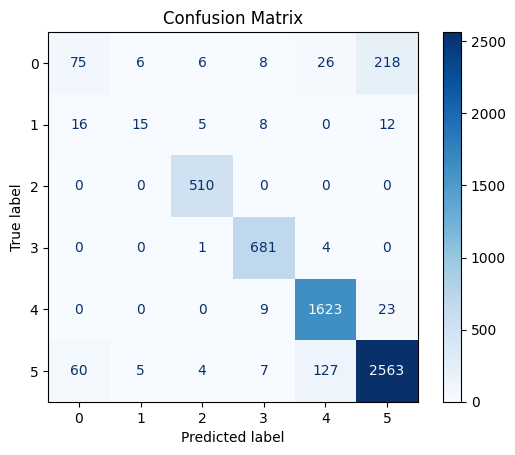


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.22      0.31       339
           1       0.58      0.27      0.37        56
           2       0.97      1.00      0.98       510
           3       0.96      0.99      0.97       686
           4       0.91      0.98      0.94      1655
           5       0.91      0.93      0.92      2766

    accuracy                           0.91      6012
   macro avg       0.80      0.73      0.75      6012
weighted avg       0.89      0.91      0.90      6012



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


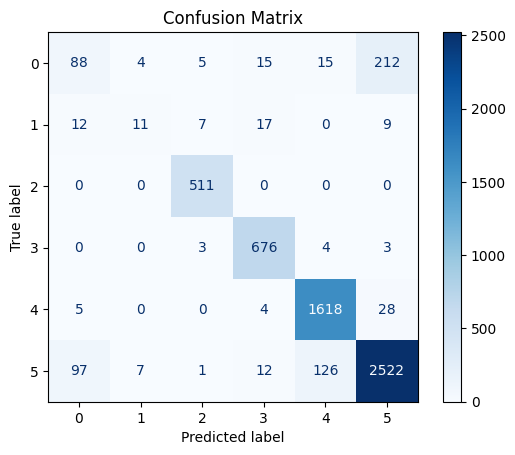


Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.26      0.33       339
           1       0.50      0.20      0.28        56
           2       0.97      1.00      0.98       511
           3       0.93      0.99      0.96       686
           4       0.92      0.98      0.95      1655
           5       0.91      0.91      0.91      2765

    accuracy                           0.90      6012
   macro avg       0.78      0.72      0.73      6012
weighted avg       0.89      0.90      0.89      6012



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


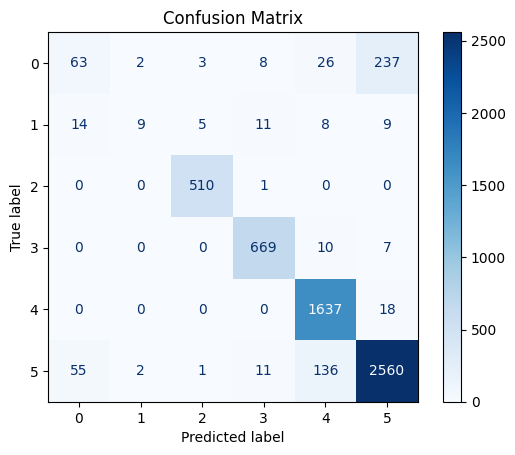


Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.19      0.27       339
           1       0.69      0.16      0.26        56
           2       0.98      1.00      0.99       511
           3       0.96      0.98      0.97       686
           4       0.90      0.99      0.94      1655
           5       0.90      0.93      0.91      2765

    accuracy                           0.91      6012
   macro avg       0.82      0.71      0.72      6012
weighted avg       0.89      0.91      0.89      6012



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


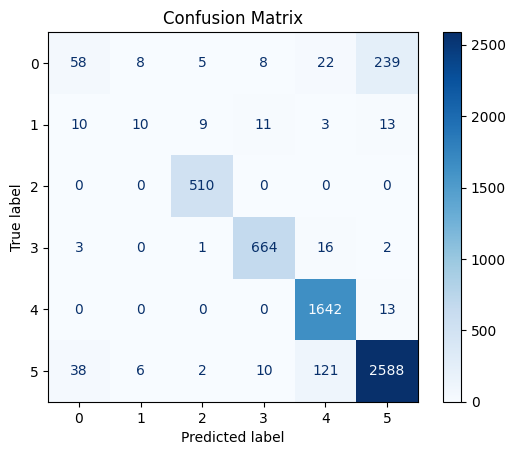


Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.17      0.26       340
           1       0.42      0.18      0.25        56
           2       0.97      1.00      0.98       510
           3       0.96      0.97      0.96       686
           4       0.91      0.99      0.95      1655
           5       0.91      0.94      0.92      2765

    accuracy                           0.91      6012
   macro avg       0.78      0.71      0.72      6012
weighted avg       0.89      0.91      0.90      6012


Average Accuracy: 0.9091
Average Precision (macro): 0.8006
Average Recall (macro): 0.7164


In [1]:
# cross-validation
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

df = pd.read_csv("Recipe Reviews and User Feedback Dataset.csv")

columns_to_drop = [
    'recipe_number', 'recipe_code', 'recipe_name',
    'comment_id', 'user_id', 'user_name', 'created_at'
]
df_cleaned = df.drop(columns=columns_to_drop)
df_cleaned = df_cleaned.dropna(subset=['text'])

texts = df_cleaned['text'].astype(str).values
labels = df_cleaned['stars'].values
numeric_features = df_cleaned[['user_reputation', 'reply_count', 'thumbs_up', 'thumbs_down', 'best_score']]

scaler = StandardScaler()
numeric_features_scaled = scaler.fit_transform(numeric_features)

MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 200

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
text_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')


def oversample_class(class_label, factor):
    indices = np.where(labels == class_label)[0]
    text_part = np.repeat(text_padded[indices], factor, axis=0)
    num_part = np.repeat(numeric_features_scaled[indices], factor, axis=0)
    label_part = np.repeat(labels[indices], factor, axis=0)
    return text_part, num_part, label_part

t2, n2, l2 = oversample_class(2, 10)
t3, n3, l3 = oversample_class(3, 6)
t4, n4, l4 = oversample_class(4, 4)

X_text_all = np.concatenate([text_padded, t2, t3, t4], axis=0)
X_num_all = np.concatenate([numeric_features_scaled, n2, n3, n4], axis=0)
y_all = np.concatenate([labels, l2, l3, l4], axis=0)

X_text_all, X_num_all, y_all = shuffle(X_text_all, X_num_all, y_all, random_state=42)


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []

for train_index, test_index in kf.split(X_text_all, y_all):
    X_text_train, X_text_test = X_text_all[train_index], X_text_all[test_index]
    X_num_train, X_num_test = X_num_all[train_index], X_num_all[test_index]
    y_train, y_test = y_all[train_index], y_all[test_index]
    
    num_classes = len(np.unique(y_train))
    y_train_cat = to_categorical(y_train, num_classes=num_classes)
    y_test_cat = to_categorical(y_test, num_classes=num_classes)

    text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name='text_input')
    x = Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH)(text_input)
    x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)

    numeric_input = Input(shape=(X_num_train.shape[1],), name='numeric_input')
    y = Dense(64, activation='relu')(numeric_input)

    combined = Concatenate()([x, y])
    z = Dense(64, activation='relu')(combined)
    z = Dropout(0.5)(z)
    z = Dense(num_classes, activation='softmax')(z)

    model = Model(inputs=[text_input, numeric_input], outputs=z)

    model.compile(
        optimizer=Adam(learning_rate=5e-4),  
        loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=['accuracy']
    )

    model.fit(
        [X_text_train, X_num_train], y_train_cat,
        validation_data=([X_text_test, X_num_test], y_test_cat),
        epochs=5,
        batch_size=32,
        verbose=0
    )

    y_pred_probs = model.predict([X_text_test, X_num_test])
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    cm_display.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)

    print(f"\nClassification Report:\n{classification_report(y_true, y_pred)}")

print(f"\nAverage Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Average Precision (macro): {np.mean(precision_scores):.4f}")
print(f"Average Recall (macro): {np.mean(recall_scores):.4f}")